In [1]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


In [8]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 200

optimizer = Adam(0.0001, 0.5)

## GENERATOR

def build_generator():

    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(2048))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

## DISCRIMINATOR

def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    #model.add(Dense(512))
    #model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

## UNIFY

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

def sample_images(h):
    r, c = 2, 2
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    #fig.savefig("images/%d.png" % epoch)
    plt.show()
    plt.close()

def train(epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = fashion_mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               51456     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_19 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dense_20 (Dense)             (None, 1024)             

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.884470, acc.: 48.44%] [G loss: 0.894340]


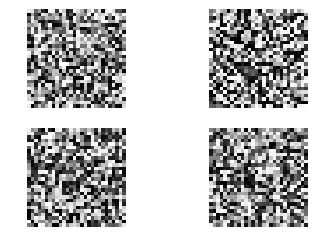

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.620578, acc.: 70.31%] [G loss: 0.839844]
2 [D loss: 0.456768, acc.: 84.38%] [G loss: 0.835299]
3 [D loss: 0.457575, acc.: 81.25%] [G loss: 0.883588]
4 [D loss: 0.368267, acc.: 85.94%] [G loss: 1.004552]
5 [D loss: 0.294200, acc.: 92.19%] [G loss: 1.015860]
6 [D loss: 0.313519, acc.: 93.75%] [G loss: 1.053493]
7 [D loss: 0.247800, acc.: 96.88%] [G loss: 1.133746]
8 [D loss: 0.242765, acc.: 96.88%] [G loss: 1.124564]
9 [D loss: 0.245402, acc.: 95.31%] [G loss: 1.256184]
10 [D loss: 0.219209, acc.: 98.44%] [G loss: 1.236397]
11 [D loss: 0.197559, acc.: 100.00%] [G loss: 1.352065]
12 [D loss: 0.189729, acc.: 98.44%] [G loss: 1.372711]
13 [D loss: 0.187097, acc.: 100.00%] [G loss: 1.482051]
14 [D loss: 0.148796, acc.: 100.00%] [G loss: 1.484759]
15 [D loss: 0.147227, acc.: 100.00%] [G loss: 1.511310]
16 [D loss: 0.150337, acc.: 100.00%] [G loss: 1.514459]
17 [D loss: 0.124454, acc.: 100.00%] [G loss: 1.627344]
18 [D loss: 0.137780, acc.: 100.00%] [G loss: 1.553302]
19 [D loss: 

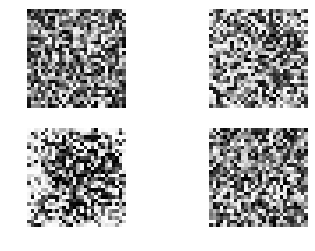

201 [D loss: 0.067085, acc.: 98.44%] [G loss: 4.000102]
202 [D loss: 0.055804, acc.: 100.00%] [G loss: 4.212968]
203 [D loss: 0.043003, acc.: 100.00%] [G loss: 4.232066]
204 [D loss: 0.038524, acc.: 100.00%] [G loss: 3.979511]
205 [D loss: 0.051490, acc.: 100.00%] [G loss: 3.878856]
206 [D loss: 0.073132, acc.: 96.88%] [G loss: 4.210659]
207 [D loss: 0.045406, acc.: 100.00%] [G loss: 4.133223]
208 [D loss: 0.083656, acc.: 98.44%] [G loss: 3.912622]
209 [D loss: 0.111170, acc.: 95.31%] [G loss: 4.048273]
210 [D loss: 0.060265, acc.: 100.00%] [G loss: 4.083930]
211 [D loss: 0.048086, acc.: 98.44%] [G loss: 4.058129]
212 [D loss: 0.033179, acc.: 100.00%] [G loss: 4.131041]
213 [D loss: 0.068096, acc.: 98.44%] [G loss: 4.021446]
214 [D loss: 0.053727, acc.: 100.00%] [G loss: 3.945209]
215 [D loss: 0.044356, acc.: 98.44%] [G loss: 4.017948]
216 [D loss: 0.050436, acc.: 98.44%] [G loss: 4.159156]
217 [D loss: 0.100892, acc.: 96.88%] [G loss: 4.106879]
218 [D loss: 0.070039, acc.: 96.88%] [G 

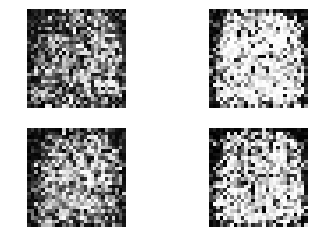

401 [D loss: 0.315516, acc.: 84.38%] [G loss: 2.742526]
402 [D loss: 0.224786, acc.: 92.19%] [G loss: 2.636558]
403 [D loss: 0.290451, acc.: 82.81%] [G loss: 2.531043]
404 [D loss: 0.432525, acc.: 89.06%] [G loss: 2.358902]
405 [D loss: 0.240623, acc.: 93.75%] [G loss: 2.802767]
406 [D loss: 0.240432, acc.: 93.75%] [G loss: 3.273132]
407 [D loss: 0.375865, acc.: 85.94%] [G loss: 2.205860]
408 [D loss: 0.328554, acc.: 87.50%] [G loss: 3.019176]
409 [D loss: 0.385591, acc.: 82.81%] [G loss: 2.645271]
410 [D loss: 0.270990, acc.: 90.62%] [G loss: 2.967180]
411 [D loss: 0.284546, acc.: 87.50%] [G loss: 2.537684]
412 [D loss: 0.376091, acc.: 85.94%] [G loss: 2.595318]
413 [D loss: 0.316312, acc.: 85.94%] [G loss: 2.507560]
414 [D loss: 0.430830, acc.: 79.69%] [G loss: 2.738216]
415 [D loss: 0.369405, acc.: 87.50%] [G loss: 3.102174]
416 [D loss: 0.389635, acc.: 84.38%] [G loss: 2.525449]
417 [D loss: 0.223124, acc.: 93.75%] [G loss: 2.723258]
418 [D loss: 0.199902, acc.: 95.31%] [G loss: 2.

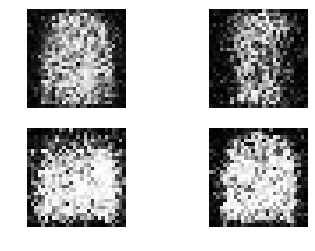

601 [D loss: 0.653434, acc.: 70.31%] [G loss: 1.129897]
602 [D loss: 0.705507, acc.: 60.94%] [G loss: 0.981704]
603 [D loss: 0.753617, acc.: 59.38%] [G loss: 1.101302]
604 [D loss: 0.679804, acc.: 62.50%] [G loss: 1.318160]
605 [D loss: 0.694070, acc.: 62.50%] [G loss: 1.243514]
606 [D loss: 0.700256, acc.: 65.62%] [G loss: 1.338738]
607 [D loss: 0.818185, acc.: 59.38%] [G loss: 1.196082]
608 [D loss: 0.928639, acc.: 50.00%] [G loss: 1.001428]
609 [D loss: 0.795760, acc.: 46.88%] [G loss: 1.136707]
610 [D loss: 0.556597, acc.: 68.75%] [G loss: 1.286643]
611 [D loss: 0.831018, acc.: 53.12%] [G loss: 1.187008]
612 [D loss: 0.828279, acc.: 59.38%] [G loss: 1.109133]
613 [D loss: 0.867460, acc.: 56.25%] [G loss: 1.168080]
614 [D loss: 0.674047, acc.: 62.50%] [G loss: 1.244371]
615 [D loss: 0.868862, acc.: 50.00%] [G loss: 1.146944]
616 [D loss: 0.657361, acc.: 71.88%] [G loss: 1.174879]
617 [D loss: 0.794461, acc.: 56.25%] [G loss: 1.114237]
618 [D loss: 0.654671, acc.: 57.81%] [G loss: 1.

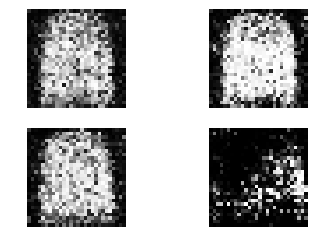

801 [D loss: 0.731820, acc.: 56.25%] [G loss: 0.967291]
802 [D loss: 0.620652, acc.: 65.62%] [G loss: 0.945509]
803 [D loss: 0.625636, acc.: 68.75%] [G loss: 0.969301]
804 [D loss: 0.562048, acc.: 73.44%] [G loss: 0.996135]
805 [D loss: 0.640856, acc.: 64.06%] [G loss: 0.955387]
806 [D loss: 0.711226, acc.: 57.81%] [G loss: 0.998843]
807 [D loss: 0.608813, acc.: 62.50%] [G loss: 0.887564]
808 [D loss: 0.594260, acc.: 73.44%] [G loss: 0.954881]
809 [D loss: 0.593814, acc.: 70.31%] [G loss: 0.901958]
810 [D loss: 0.607722, acc.: 62.50%] [G loss: 1.036147]
811 [D loss: 0.632169, acc.: 67.19%] [G loss: 0.967509]
812 [D loss: 0.597796, acc.: 68.75%] [G loss: 0.961554]
813 [D loss: 0.663244, acc.: 59.38%] [G loss: 0.898340]
814 [D loss: 0.595985, acc.: 67.19%] [G loss: 0.942118]
815 [D loss: 0.634872, acc.: 60.94%] [G loss: 0.880881]
816 [D loss: 0.601875, acc.: 60.94%] [G loss: 0.978311]
817 [D loss: 0.590346, acc.: 67.19%] [G loss: 1.023702]
818 [D loss: 0.537277, acc.: 78.12%] [G loss: 1.

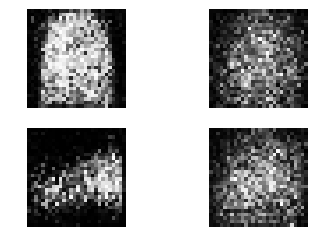

1001 [D loss: 0.587624, acc.: 70.31%] [G loss: 0.984824]
1002 [D loss: 0.717682, acc.: 56.25%] [G loss: 0.961781]
1003 [D loss: 0.633771, acc.: 60.94%] [G loss: 0.930123]
1004 [D loss: 0.650378, acc.: 68.75%] [G loss: 0.977820]
1005 [D loss: 0.569390, acc.: 76.56%] [G loss: 0.912938]
1006 [D loss: 0.621191, acc.: 64.06%] [G loss: 0.912259]
1007 [D loss: 0.692907, acc.: 53.12%] [G loss: 0.876287]
1008 [D loss: 0.725343, acc.: 62.50%] [G loss: 0.843643]
1009 [D loss: 0.642010, acc.: 62.50%] [G loss: 0.924357]
1010 [D loss: 0.582599, acc.: 67.19%] [G loss: 0.951102]
1011 [D loss: 0.648483, acc.: 60.94%] [G loss: 0.917744]
1012 [D loss: 0.703750, acc.: 51.56%] [G loss: 0.955372]
1013 [D loss: 0.658128, acc.: 64.06%] [G loss: 0.809602]
1014 [D loss: 0.602727, acc.: 71.88%] [G loss: 0.906436]
1015 [D loss: 0.591543, acc.: 60.94%] [G loss: 0.939130]
1016 [D loss: 0.653359, acc.: 60.94%] [G loss: 0.896512]
1017 [D loss: 0.666166, acc.: 60.94%] [G loss: 0.930547]
1018 [D loss: 0.672985, acc.: 5

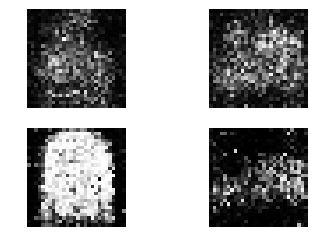

1201 [D loss: 0.620215, acc.: 64.06%] [G loss: 0.893003]
1202 [D loss: 0.733105, acc.: 56.25%] [G loss: 0.924661]
1203 [D loss: 0.591051, acc.: 75.00%] [G loss: 0.911173]
1204 [D loss: 0.607717, acc.: 60.94%] [G loss: 0.923477]
1205 [D loss: 0.607319, acc.: 73.44%] [G loss: 0.897224]
1206 [D loss: 0.648170, acc.: 60.94%] [G loss: 0.905830]
1207 [D loss: 0.627309, acc.: 56.25%] [G loss: 0.890564]
1208 [D loss: 0.598922, acc.: 70.31%] [G loss: 0.939153]
1209 [D loss: 0.651530, acc.: 60.94%] [G loss: 0.903843]
1210 [D loss: 0.593114, acc.: 68.75%] [G loss: 0.836426]
1211 [D loss: 0.585959, acc.: 67.19%] [G loss: 0.896144]
1212 [D loss: 0.579580, acc.: 73.44%] [G loss: 0.918835]
1213 [D loss: 0.655294, acc.: 64.06%] [G loss: 0.915400]
1214 [D loss: 0.618259, acc.: 60.94%] [G loss: 0.941985]
1215 [D loss: 0.645900, acc.: 62.50%] [G loss: 0.907496]
1216 [D loss: 0.615046, acc.: 71.88%] [G loss: 0.926062]
1217 [D loss: 0.588901, acc.: 75.00%] [G loss: 0.993912]
1218 [D loss: 0.643396, acc.: 6

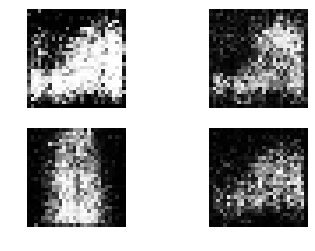

1401 [D loss: 0.605471, acc.: 64.06%] [G loss: 0.877423]
1402 [D loss: 0.551006, acc.: 73.44%] [G loss: 0.884657]
1403 [D loss: 0.622008, acc.: 62.50%] [G loss: 0.859986]
1404 [D loss: 0.555094, acc.: 68.75%] [G loss: 0.861651]
1405 [D loss: 0.529444, acc.: 73.44%] [G loss: 0.839260]
1406 [D loss: 0.562008, acc.: 70.31%] [G loss: 0.941736]
1407 [D loss: 0.683413, acc.: 56.25%] [G loss: 0.810141]
1408 [D loss: 0.595669, acc.: 68.75%] [G loss: 0.902703]
1409 [D loss: 0.600751, acc.: 65.62%] [G loss: 0.860284]
1410 [D loss: 0.612666, acc.: 64.06%] [G loss: 0.850897]
1411 [D loss: 0.611678, acc.: 64.06%] [G loss: 0.852792]
1412 [D loss: 0.604642, acc.: 68.75%] [G loss: 0.931449]
1413 [D loss: 0.639759, acc.: 64.06%] [G loss: 0.884891]
1414 [D loss: 0.641457, acc.: 59.38%] [G loss: 0.783728]
1415 [D loss: 0.570255, acc.: 71.88%] [G loss: 0.868821]
1416 [D loss: 0.628793, acc.: 62.50%] [G loss: 0.884636]
1417 [D loss: 0.595709, acc.: 67.19%] [G loss: 0.922613]
1418 [D loss: 0.596526, acc.: 7

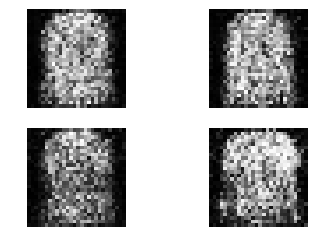

1601 [D loss: 0.651415, acc.: 59.38%] [G loss: 0.854985]
1602 [D loss: 0.648466, acc.: 67.19%] [G loss: 0.819039]
1603 [D loss: 0.629967, acc.: 62.50%] [G loss: 0.824579]
1604 [D loss: 0.595680, acc.: 71.88%] [G loss: 0.866384]
1605 [D loss: 0.626460, acc.: 65.62%] [G loss: 0.856119]
1606 [D loss: 0.635215, acc.: 64.06%] [G loss: 0.866840]
1607 [D loss: 0.610648, acc.: 68.75%] [G loss: 0.773668]
1608 [D loss: 0.690248, acc.: 57.81%] [G loss: 0.834028]
1609 [D loss: 0.701013, acc.: 60.94%] [G loss: 0.864916]
1610 [D loss: 0.674645, acc.: 57.81%] [G loss: 0.799922]
1611 [D loss: 0.660566, acc.: 64.06%] [G loss: 0.888980]
1612 [D loss: 0.586949, acc.: 68.75%] [G loss: 0.801907]
1613 [D loss: 0.675667, acc.: 57.81%] [G loss: 0.792463]
1614 [D loss: 0.602117, acc.: 67.19%] [G loss: 0.837928]
1615 [D loss: 0.667765, acc.: 54.69%] [G loss: 0.799816]
1616 [D loss: 0.660465, acc.: 67.19%] [G loss: 0.748544]
1617 [D loss: 0.666038, acc.: 64.06%] [G loss: 0.798856]
1618 [D loss: 0.629444, acc.: 5

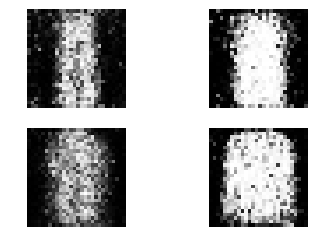

1801 [D loss: 0.626943, acc.: 67.19%] [G loss: 0.900546]
1802 [D loss: 0.599329, acc.: 68.75%] [G loss: 0.821863]
1803 [D loss: 0.622083, acc.: 67.19%] [G loss: 0.810592]
1804 [D loss: 0.563786, acc.: 76.56%] [G loss: 0.798298]
1805 [D loss: 0.698361, acc.: 53.12%] [G loss: 0.782917]
1806 [D loss: 0.650254, acc.: 57.81%] [G loss: 0.801742]
1807 [D loss: 0.682802, acc.: 50.00%] [G loss: 0.919756]
1808 [D loss: 0.653086, acc.: 60.94%] [G loss: 0.874735]
1809 [D loss: 0.616178, acc.: 67.19%] [G loss: 0.825075]
1810 [D loss: 0.619060, acc.: 65.62%] [G loss: 0.837138]
1811 [D loss: 0.602713, acc.: 62.50%] [G loss: 0.848464]
1812 [D loss: 0.604308, acc.: 62.50%] [G loss: 0.834693]
1813 [D loss: 0.638799, acc.: 60.94%] [G loss: 0.893771]
1814 [D loss: 0.574410, acc.: 70.31%] [G loss: 0.829811]
1815 [D loss: 0.604614, acc.: 71.88%] [G loss: 0.848522]
1816 [D loss: 0.645677, acc.: 65.62%] [G loss: 0.840193]
1817 [D loss: 0.656574, acc.: 57.81%] [G loss: 0.789726]
1818 [D loss: 0.609571, acc.: 6

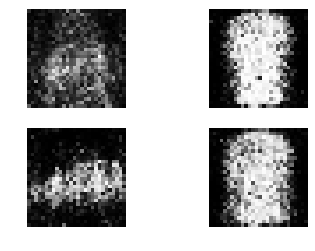

2001 [D loss: 0.663199, acc.: 56.25%] [G loss: 0.787963]
2002 [D loss: 0.638301, acc.: 65.62%] [G loss: 0.847494]
2003 [D loss: 0.622120, acc.: 73.44%] [G loss: 0.846669]
2004 [D loss: 0.618917, acc.: 60.94%] [G loss: 0.884747]
2005 [D loss: 0.618554, acc.: 65.62%] [G loss: 0.846811]
2006 [D loss: 0.657217, acc.: 59.38%] [G loss: 0.825138]
2007 [D loss: 0.662743, acc.: 48.44%] [G loss: 0.772905]
2008 [D loss: 0.637715, acc.: 62.50%] [G loss: 0.822823]
2009 [D loss: 0.626139, acc.: 68.75%] [G loss: 0.891551]
2010 [D loss: 0.634508, acc.: 71.88%] [G loss: 0.833528]
2011 [D loss: 0.641710, acc.: 64.06%] [G loss: 0.860653]
2012 [D loss: 0.690205, acc.: 60.94%] [G loss: 0.824480]
2013 [D loss: 0.609443, acc.: 70.31%] [G loss: 0.861571]
2014 [D loss: 0.608944, acc.: 68.75%] [G loss: 0.853676]
2015 [D loss: 0.658563, acc.: 60.94%] [G loss: 0.939861]
2016 [D loss: 0.668970, acc.: 57.81%] [G loss: 0.837274]
2017 [D loss: 0.599406, acc.: 64.06%] [G loss: 0.827568]
2018 [D loss: 0.598071, acc.: 7

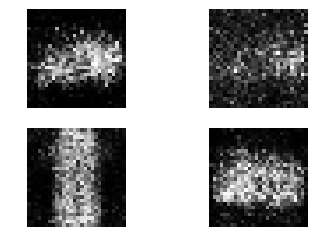

2201 [D loss: 0.605090, acc.: 68.75%] [G loss: 0.876288]
2202 [D loss: 0.625234, acc.: 65.62%] [G loss: 0.841099]
2203 [D loss: 0.697913, acc.: 48.44%] [G loss: 0.784543]
2204 [D loss: 0.656701, acc.: 56.25%] [G loss: 0.882122]
2205 [D loss: 0.644234, acc.: 57.81%] [G loss: 0.771715]
2206 [D loss: 0.640740, acc.: 57.81%] [G loss: 0.833563]
2207 [D loss: 0.653513, acc.: 56.25%] [G loss: 0.877289]
2208 [D loss: 0.613559, acc.: 64.06%] [G loss: 0.833841]
2209 [D loss: 0.613447, acc.: 67.19%] [G loss: 0.775144]
2210 [D loss: 0.635916, acc.: 64.06%] [G loss: 0.751375]
2211 [D loss: 0.681972, acc.: 48.44%] [G loss: 0.787393]
2212 [D loss: 0.621056, acc.: 57.81%] [G loss: 0.837695]
2213 [D loss: 0.659506, acc.: 57.81%] [G loss: 0.872200]
2214 [D loss: 0.580654, acc.: 70.31%] [G loss: 0.913207]
2215 [D loss: 0.638970, acc.: 57.81%] [G loss: 0.841734]
2216 [D loss: 0.669304, acc.: 56.25%] [G loss: 0.884730]
2217 [D loss: 0.612931, acc.: 64.06%] [G loss: 0.920707]
2218 [D loss: 0.649976, acc.: 6

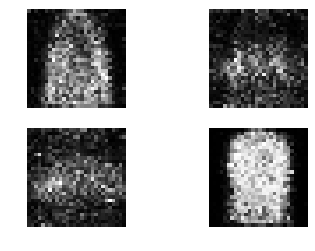

2401 [D loss: 0.671830, acc.: 64.06%] [G loss: 0.842060]
2402 [D loss: 0.670427, acc.: 57.81%] [G loss: 0.786953]
2403 [D loss: 0.596617, acc.: 70.31%] [G loss: 0.891714]
2404 [D loss: 0.604663, acc.: 68.75%] [G loss: 0.844002]
2405 [D loss: 0.639340, acc.: 71.88%] [G loss: 0.850020]
2406 [D loss: 0.666241, acc.: 56.25%] [G loss: 0.744996]
2407 [D loss: 0.651556, acc.: 64.06%] [G loss: 0.839603]
2408 [D loss: 0.637224, acc.: 57.81%] [G loss: 0.906218]
2409 [D loss: 0.591466, acc.: 73.44%] [G loss: 0.857618]
2410 [D loss: 0.659516, acc.: 59.38%] [G loss: 0.812596]
2411 [D loss: 0.642454, acc.: 59.38%] [G loss: 0.774808]
2412 [D loss: 0.646614, acc.: 59.38%] [G loss: 0.784382]
2413 [D loss: 0.636943, acc.: 60.94%] [G loss: 0.823228]
2414 [D loss: 0.594586, acc.: 70.31%] [G loss: 0.843286]
2415 [D loss: 0.656665, acc.: 54.69%] [G loss: 0.851082]
2416 [D loss: 0.616603, acc.: 65.62%] [G loss: 0.863288]
2417 [D loss: 0.674161, acc.: 62.50%] [G loss: 0.818467]
2418 [D loss: 0.632287, acc.: 6

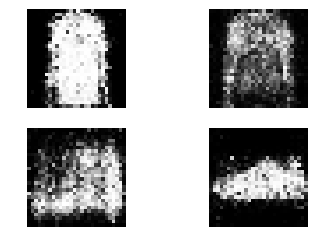

2601 [D loss: 0.652182, acc.: 67.19%] [G loss: 0.811010]
2602 [D loss: 0.674301, acc.: 57.81%] [G loss: 0.841145]
2603 [D loss: 0.581005, acc.: 78.12%] [G loss: 0.781066]
2604 [D loss: 0.631794, acc.: 65.62%] [G loss: 0.912264]
2605 [D loss: 0.581746, acc.: 76.56%] [G loss: 0.779686]
2606 [D loss: 0.586989, acc.: 70.31%] [G loss: 0.842162]
2607 [D loss: 0.633002, acc.: 65.62%] [G loss: 0.894329]
2608 [D loss: 0.609288, acc.: 65.62%] [G loss: 0.903604]
2609 [D loss: 0.579525, acc.: 75.00%] [G loss: 0.827802]
2610 [D loss: 0.580043, acc.: 70.31%] [G loss: 0.853030]
2611 [D loss: 0.657366, acc.: 64.06%] [G loss: 0.909061]
2612 [D loss: 0.591660, acc.: 70.31%] [G loss: 0.874252]
2613 [D loss: 0.669142, acc.: 56.25%] [G loss: 0.936644]
2614 [D loss: 0.587953, acc.: 65.62%] [G loss: 0.902216]
2615 [D loss: 0.619872, acc.: 62.50%] [G loss: 0.893150]
2616 [D loss: 0.598042, acc.: 65.62%] [G loss: 0.841257]
2617 [D loss: 0.579025, acc.: 70.31%] [G loss: 0.950595]
2618 [D loss: 0.654893, acc.: 5

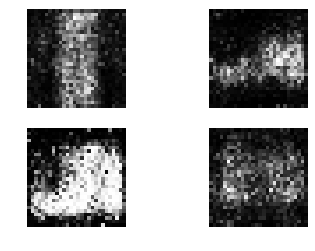

2801 [D loss: 0.618010, acc.: 70.31%] [G loss: 0.871584]
2802 [D loss: 0.615171, acc.: 73.44%] [G loss: 0.796044]
2803 [D loss: 0.621403, acc.: 59.38%] [G loss: 0.845780]
2804 [D loss: 0.634233, acc.: 59.38%] [G loss: 0.775004]
2805 [D loss: 0.616413, acc.: 65.62%] [G loss: 0.836050]
2806 [D loss: 0.608376, acc.: 64.06%] [G loss: 0.885029]
2807 [D loss: 0.584358, acc.: 71.88%] [G loss: 0.858347]
2808 [D loss: 0.603672, acc.: 65.62%] [G loss: 0.845816]
2809 [D loss: 0.586972, acc.: 70.31%] [G loss: 0.907029]
2810 [D loss: 0.618940, acc.: 64.06%] [G loss: 0.910962]
2811 [D loss: 0.599350, acc.: 71.88%] [G loss: 0.845341]
2812 [D loss: 0.637372, acc.: 65.62%] [G loss: 0.831931]
2813 [D loss: 0.617842, acc.: 65.62%] [G loss: 0.842468]
2814 [D loss: 0.568305, acc.: 75.00%] [G loss: 0.881441]
2815 [D loss: 0.634118, acc.: 70.31%] [G loss: 0.841078]
2816 [D loss: 0.640800, acc.: 59.38%] [G loss: 0.828980]
2817 [D loss: 0.630677, acc.: 67.19%] [G loss: 0.843470]
2818 [D loss: 0.605695, acc.: 6

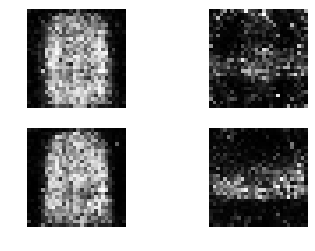

3001 [D loss: 0.582497, acc.: 70.31%] [G loss: 0.917913]
3002 [D loss: 0.618473, acc.: 65.62%] [G loss: 0.829328]
3003 [D loss: 0.590418, acc.: 71.88%] [G loss: 0.887721]
3004 [D loss: 0.577337, acc.: 70.31%] [G loss: 0.909173]
3005 [D loss: 0.646017, acc.: 60.94%] [G loss: 0.888568]
3006 [D loss: 0.589370, acc.: 73.44%] [G loss: 0.902693]
3007 [D loss: 0.617466, acc.: 65.62%] [G loss: 0.855459]
3008 [D loss: 0.648721, acc.: 62.50%] [G loss: 0.881396]
3009 [D loss: 0.589955, acc.: 67.19%] [G loss: 0.860497]
3010 [D loss: 0.649941, acc.: 65.62%] [G loss: 0.949225]
3011 [D loss: 0.656543, acc.: 60.94%] [G loss: 0.868806]
3012 [D loss: 0.673156, acc.: 57.81%] [G loss: 0.845199]
3013 [D loss: 0.611571, acc.: 60.94%] [G loss: 0.873236]
3014 [D loss: 0.622972, acc.: 67.19%] [G loss: 0.848540]
3015 [D loss: 0.602422, acc.: 68.75%] [G loss: 0.877670]
3016 [D loss: 0.637512, acc.: 64.06%] [G loss: 0.843991]
3017 [D loss: 0.623915, acc.: 62.50%] [G loss: 0.867990]
3018 [D loss: 0.689932, acc.: 5

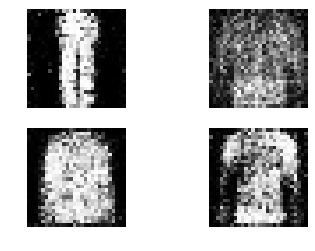

3201 [D loss: 0.634653, acc.: 64.06%] [G loss: 0.915218]
3202 [D loss: 0.577194, acc.: 67.19%] [G loss: 1.046856]
3203 [D loss: 0.614370, acc.: 68.75%] [G loss: 0.898684]
3204 [D loss: 0.609694, acc.: 64.06%] [G loss: 0.998722]
3205 [D loss: 0.584672, acc.: 65.62%] [G loss: 0.955131]
3206 [D loss: 0.647528, acc.: 60.94%] [G loss: 0.913087]
3207 [D loss: 0.657856, acc.: 62.50%] [G loss: 0.927223]
3208 [D loss: 0.589309, acc.: 70.31%] [G loss: 0.923318]
3209 [D loss: 0.641795, acc.: 62.50%] [G loss: 0.862332]
3210 [D loss: 0.594438, acc.: 71.88%] [G loss: 0.916621]
3211 [D loss: 0.554600, acc.: 70.31%] [G loss: 0.905395]
3212 [D loss: 0.649303, acc.: 56.25%] [G loss: 1.028329]
3213 [D loss: 0.595524, acc.: 70.31%] [G loss: 0.904934]
3214 [D loss: 0.623470, acc.: 64.06%] [G loss: 0.835221]
3215 [D loss: 0.628590, acc.: 64.06%] [G loss: 0.867523]
3216 [D loss: 0.649252, acc.: 60.94%] [G loss: 0.883170]
3217 [D loss: 0.636528, acc.: 67.19%] [G loss: 0.904347]
3218 [D loss: 0.631569, acc.: 6

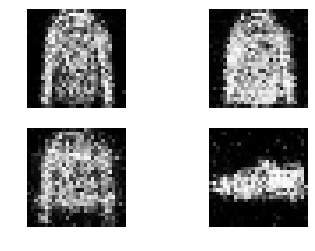

3401 [D loss: 0.600316, acc.: 75.00%] [G loss: 0.846378]
3402 [D loss: 0.644689, acc.: 56.25%] [G loss: 0.931445]
3403 [D loss: 0.611442, acc.: 71.88%] [G loss: 0.922917]
3404 [D loss: 0.634419, acc.: 60.94%] [G loss: 0.895375]
3405 [D loss: 0.593298, acc.: 65.62%] [G loss: 0.914415]
3406 [D loss: 0.666357, acc.: 59.38%] [G loss: 0.923664]
3407 [D loss: 0.591884, acc.: 71.88%] [G loss: 0.869399]
3408 [D loss: 0.621235, acc.: 68.75%] [G loss: 0.899185]
3409 [D loss: 0.619257, acc.: 67.19%] [G loss: 0.770024]
3410 [D loss: 0.601572, acc.: 65.62%] [G loss: 0.901222]
3411 [D loss: 0.580308, acc.: 70.31%] [G loss: 0.918034]
3412 [D loss: 0.562597, acc.: 73.44%] [G loss: 0.931058]
3413 [D loss: 0.576534, acc.: 67.19%] [G loss: 0.905893]
3414 [D loss: 0.611024, acc.: 68.75%] [G loss: 0.888555]
3415 [D loss: 0.634311, acc.: 65.62%] [G loss: 0.855064]
3416 [D loss: 0.610541, acc.: 65.62%] [G loss: 0.877104]
3417 [D loss: 0.665787, acc.: 53.12%] [G loss: 0.828798]
3418 [D loss: 0.648038, acc.: 5

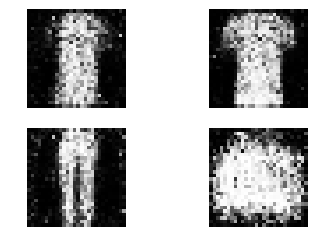

3601 [D loss: 0.648517, acc.: 59.38%] [G loss: 0.944366]
3602 [D loss: 0.627825, acc.: 70.31%] [G loss: 0.879565]
3603 [D loss: 0.592545, acc.: 76.56%] [G loss: 0.899173]
3604 [D loss: 0.582934, acc.: 75.00%] [G loss: 0.904631]
3605 [D loss: 0.677487, acc.: 60.94%] [G loss: 0.841737]
3606 [D loss: 0.655100, acc.: 54.69%] [G loss: 0.821106]
3607 [D loss: 0.607741, acc.: 62.50%] [G loss: 0.919675]
3608 [D loss: 0.620314, acc.: 64.06%] [G loss: 0.890826]
3609 [D loss: 0.623965, acc.: 62.50%] [G loss: 0.880336]
3610 [D loss: 0.598082, acc.: 64.06%] [G loss: 0.905622]
3611 [D loss: 0.633978, acc.: 64.06%] [G loss: 0.847138]
3612 [D loss: 0.647472, acc.: 60.94%] [G loss: 0.928960]
3613 [D loss: 0.604295, acc.: 62.50%] [G loss: 0.920959]
3614 [D loss: 0.592474, acc.: 65.62%] [G loss: 0.892666]
3615 [D loss: 0.626889, acc.: 65.62%] [G loss: 0.935441]
3616 [D loss: 0.659452, acc.: 64.06%] [G loss: 0.958533]
3617 [D loss: 0.610421, acc.: 70.31%] [G loss: 0.910069]
3618 [D loss: 0.621349, acc.: 6

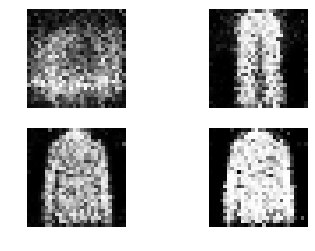

3801 [D loss: 0.594241, acc.: 67.19%] [G loss: 0.908378]
3802 [D loss: 0.665930, acc.: 53.12%] [G loss: 0.973729]
3803 [D loss: 0.576683, acc.: 71.88%] [G loss: 0.823024]
3804 [D loss: 0.666280, acc.: 56.25%] [G loss: 0.891178]
3805 [D loss: 0.662913, acc.: 57.81%] [G loss: 0.839719]
3806 [D loss: 0.622162, acc.: 60.94%] [G loss: 0.852125]
3807 [D loss: 0.683790, acc.: 54.69%] [G loss: 0.794009]
3808 [D loss: 0.566907, acc.: 73.44%] [G loss: 0.833870]
3809 [D loss: 0.664588, acc.: 56.25%] [G loss: 0.876257]
3810 [D loss: 0.635557, acc.: 62.50%] [G loss: 0.839892]
3811 [D loss: 0.644090, acc.: 65.62%] [G loss: 0.929275]
3812 [D loss: 0.634226, acc.: 62.50%] [G loss: 0.815802]
3813 [D loss: 0.601225, acc.: 68.75%] [G loss: 0.876039]
3814 [D loss: 0.651658, acc.: 62.50%] [G loss: 0.855130]
3815 [D loss: 0.607424, acc.: 70.31%] [G loss: 0.864628]
3816 [D loss: 0.599367, acc.: 67.19%] [G loss: 0.847896]
3817 [D loss: 0.587295, acc.: 68.75%] [G loss: 0.902621]
3818 [D loss: 0.623443, acc.: 7

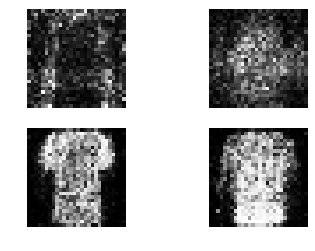

4001 [D loss: 0.621495, acc.: 64.06%] [G loss: 0.823680]
4002 [D loss: 0.656748, acc.: 60.94%] [G loss: 0.780835]
4003 [D loss: 0.572229, acc.: 67.19%] [G loss: 0.867025]
4004 [D loss: 0.634834, acc.: 57.81%] [G loss: 0.807477]
4005 [D loss: 0.537764, acc.: 82.81%] [G loss: 0.889380]
4006 [D loss: 0.662721, acc.: 54.69%] [G loss: 0.850121]
4007 [D loss: 0.568653, acc.: 71.88%] [G loss: 0.881085]
4008 [D loss: 0.630385, acc.: 64.06%] [G loss: 0.959475]
4009 [D loss: 0.604317, acc.: 67.19%] [G loss: 0.923197]
4010 [D loss: 0.624409, acc.: 65.62%] [G loss: 0.899624]
4011 [D loss: 0.631245, acc.: 57.81%] [G loss: 0.868142]
4012 [D loss: 0.658855, acc.: 54.69%] [G loss: 0.957171]
4013 [D loss: 0.560423, acc.: 79.69%] [G loss: 0.970646]
4014 [D loss: 0.593639, acc.: 67.19%] [G loss: 0.912132]
4015 [D loss: 0.651499, acc.: 64.06%] [G loss: 0.912952]
4016 [D loss: 0.613556, acc.: 73.44%] [G loss: 0.795264]
4017 [D loss: 0.625903, acc.: 65.62%] [G loss: 0.887227]
4018 [D loss: 0.639426, acc.: 6

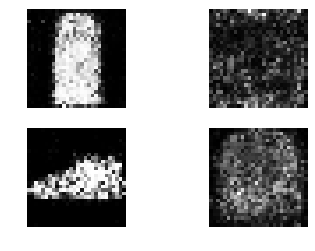

4201 [D loss: 0.663931, acc.: 53.12%] [G loss: 0.900315]
4202 [D loss: 0.670936, acc.: 51.56%] [G loss: 0.908838]
4203 [D loss: 0.681076, acc.: 56.25%] [G loss: 0.853588]
4204 [D loss: 0.650616, acc.: 57.81%] [G loss: 0.872419]
4205 [D loss: 0.626901, acc.: 62.50%] [G loss: 0.907067]
4206 [D loss: 0.662963, acc.: 60.94%] [G loss: 0.856616]
4207 [D loss: 0.630650, acc.: 62.50%] [G loss: 0.852785]
4208 [D loss: 0.614978, acc.: 71.88%] [G loss: 0.849649]
4209 [D loss: 0.641605, acc.: 57.81%] [G loss: 0.915124]
4210 [D loss: 0.719922, acc.: 51.56%] [G loss: 0.812678]
4211 [D loss: 0.669400, acc.: 54.69%] [G loss: 0.820092]
4212 [D loss: 0.584558, acc.: 67.19%] [G loss: 0.951508]
4213 [D loss: 0.621618, acc.: 67.19%] [G loss: 0.902326]
4214 [D loss: 0.673216, acc.: 56.25%] [G loss: 0.867447]
4215 [D loss: 0.644110, acc.: 64.06%] [G loss: 0.945152]
4216 [D loss: 0.704099, acc.: 53.12%] [G loss: 0.849157]
4217 [D loss: 0.660675, acc.: 56.25%] [G loss: 0.993536]
4218 [D loss: 0.701596, acc.: 5

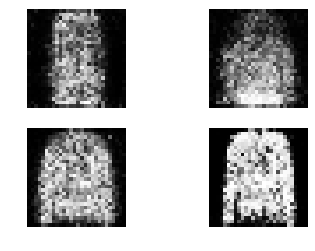

4401 [D loss: 0.624912, acc.: 65.62%] [G loss: 0.850218]
4402 [D loss: 0.621841, acc.: 60.94%] [G loss: 0.931039]
4403 [D loss: 0.666036, acc.: 60.94%] [G loss: 0.878425]
4404 [D loss: 0.586216, acc.: 75.00%] [G loss: 0.862629]
4405 [D loss: 0.600678, acc.: 64.06%] [G loss: 0.903933]
4406 [D loss: 0.609121, acc.: 64.06%] [G loss: 0.921491]
4407 [D loss: 0.624263, acc.: 60.94%] [G loss: 0.818732]
4408 [D loss: 0.666427, acc.: 64.06%] [G loss: 0.868345]
4409 [D loss: 0.677963, acc.: 53.12%] [G loss: 0.896651]
4410 [D loss: 0.648287, acc.: 62.50%] [G loss: 0.841631]
4411 [D loss: 0.575152, acc.: 78.12%] [G loss: 0.919937]
4412 [D loss: 0.694965, acc.: 51.56%] [G loss: 0.873275]
4413 [D loss: 0.636263, acc.: 65.62%] [G loss: 0.919864]
4414 [D loss: 0.591544, acc.: 67.19%] [G loss: 0.952646]
4415 [D loss: 0.645001, acc.: 59.38%] [G loss: 0.830787]
4416 [D loss: 0.654792, acc.: 53.12%] [G loss: 0.915476]
4417 [D loss: 0.638110, acc.: 53.12%] [G loss: 0.892944]
4418 [D loss: 0.580703, acc.: 6

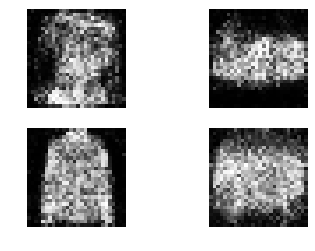

4601 [D loss: 0.655988, acc.: 57.81%] [G loss: 0.855887]
4602 [D loss: 0.644144, acc.: 64.06%] [G loss: 0.845496]
4603 [D loss: 0.600139, acc.: 67.19%] [G loss: 0.922915]
4604 [D loss: 0.673137, acc.: 62.50%] [G loss: 0.826308]
4605 [D loss: 0.655501, acc.: 59.38%] [G loss: 0.891380]
4606 [D loss: 0.630828, acc.: 65.62%] [G loss: 0.828277]
4607 [D loss: 0.677319, acc.: 62.50%] [G loss: 0.882596]
4608 [D loss: 0.597554, acc.: 71.88%] [G loss: 0.865994]
4609 [D loss: 0.525258, acc.: 78.12%] [G loss: 0.912030]
4610 [D loss: 0.630342, acc.: 64.06%] [G loss: 0.857138]
4611 [D loss: 0.613568, acc.: 67.19%] [G loss: 0.932398]
4612 [D loss: 0.638202, acc.: 60.94%] [G loss: 0.833513]
4613 [D loss: 0.663483, acc.: 56.25%] [G loss: 0.850783]
4614 [D loss: 0.695827, acc.: 56.25%] [G loss: 0.878497]
4615 [D loss: 0.642663, acc.: 54.69%] [G loss: 0.854518]
4616 [D loss: 0.641611, acc.: 60.94%] [G loss: 0.910884]
4617 [D loss: 0.633757, acc.: 64.06%] [G loss: 0.885602]
4618 [D loss: 0.639295, acc.: 5

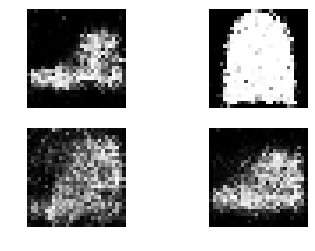

4801 [D loss: 0.611823, acc.: 62.50%] [G loss: 0.868962]
4802 [D loss: 0.599585, acc.: 68.75%] [G loss: 0.849427]
4803 [D loss: 0.655658, acc.: 57.81%] [G loss: 0.915722]
4804 [D loss: 0.600503, acc.: 68.75%] [G loss: 0.873821]
4805 [D loss: 0.655990, acc.: 60.94%] [G loss: 0.894463]
4806 [D loss: 0.593577, acc.: 71.88%] [G loss: 0.887340]
4807 [D loss: 0.605128, acc.: 67.19%] [G loss: 0.909162]
4808 [D loss: 0.642283, acc.: 59.38%] [G loss: 0.811212]
4809 [D loss: 0.587344, acc.: 67.19%] [G loss: 0.871438]
4810 [D loss: 0.625081, acc.: 65.62%] [G loss: 0.829083]
4811 [D loss: 0.656688, acc.: 57.81%] [G loss: 0.808701]
4812 [D loss: 0.691353, acc.: 62.50%] [G loss: 0.901144]
4813 [D loss: 0.614785, acc.: 62.50%] [G loss: 0.858770]
4814 [D loss: 0.602190, acc.: 59.38%] [G loss: 0.857788]
4815 [D loss: 0.653843, acc.: 62.50%] [G loss: 0.872330]
4816 [D loss: 0.653801, acc.: 64.06%] [G loss: 0.866724]
4817 [D loss: 0.642285, acc.: 70.31%] [G loss: 0.930807]
4818 [D loss: 0.656899, acc.: 5

In [9]:
train(epochs=5000, batch_size=32, sample_interval=200)

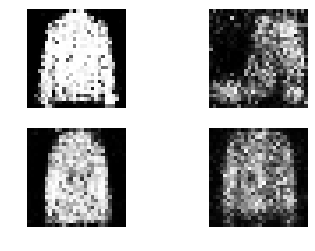

In [13]:
sample_images(0)